
# Incremental SVM vs Traditional SVM  
**Dataset:** Kaggle Fraud Detection Dataset  

---

## Objective
Traditional SVM needs full retraining whenever new data arrives — too slow for streaming systems.  
Incremental SVM (ISVM) updates the model continuously without forgetting old knowledge.

This notebook compares:
- Training time of Traditional SVM vs Incremental SVM  
- Accuracy comparison  
- Update time when new data streams in  
- Visualizations using Matplotlib  


In [68]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import time
import joblib

# Load dataset (user must upload the CSV file to /mnt/data)
df = pd.read_csv('fraudTrain.csv')  # CHANGE FILENAME IF NEEDED

df.head()


,Unnamed: 0,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,...,lat,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud
0,0,2019-01-01 00:00:18,2703186189652095,"fraud_Rippin, Kub and Mann",misc_net,4.97,Jennifer,Banks,F,561 Perry Cove,...,36.0788,-81.1781,3495,"Psychologist, counselling",1988-03-09,0b242abb623afc578575680df30655b9,1325376018,36.011293,-82.048315,0
1,1,2019-01-01 00:00:44,630423337322,"fraud_Heller, Gutmann and Zieme",grocery_pos,107.23,Stephanie,Gill,F,43039 Riley Greens Suite 393,...,48.8878,-118.2105,149,Special educational needs teacher,1978-06-21,1f76529f8574734946361c461b024d99,1325376044,49.159047,-118.186462,0
2,2,2019-01-01 00:00:51,38859492057661,fraud_Lind-Buckridge,entertainment,220.11,Edward,Sanchez,M,594 White Dale Suite 530,...,42.1808,-112.2620,4154,Nature conservation officer,1962-01-19,a1a22d70485983eac12b5b88dad1cf95,1325376051,43.150704,-112.154481,0
3,3,2019-01-01 00:01:16,3534093764340240,"fraud_Kutch, Hermiston and Farrell",gas_transport,45.00,Jeremy,White,M,9443 Cynthia Court Apt. 038,...,46.2306,-112.1138,1939,Patent attorney,1967-01-12,6b849c168bdad6f867558c3793159a81,1325376076,47.034331,-112.561071,0
4,4,2019-01-01 00:03:06,375534208663984,fraud_Keeling-Crist,misc_pos,41.96,Tyler,Garcia,M,408 Bradley Rest,...,38.4207,-79.4629,99,Dance movement psychotherapist,1986-03-28,a41d7549acf90789359a9aa5346dcb46,1325376186,38.674999,-78.632459,0


In [69]:
df['dob'] = pd.to_datetime(df['dob'], errors='coerce')
df['age'] = 2025 - df['dob'].dt.year
df['age'].fillna(df['age'].median(), inplace=True)

# ----------- HOUR ----------
df['trans_date_trans_time'] = pd.to_datetime(df['trans_date_trans_time'])
df['hour'] = df['trans_date_trans_time'].dt.hour

# ----------- BALANCING ----------
fraud = df[df['is_fraud'] == 1]
legit = df[df['is_fraud'] == 0].sample(len(fraud), random_state=42)

balanced = pd.concat([fraud, legit]).sample(frac=1, random_state=42)

# ----------- FINAL COLUMNS ----------
final = balanced[['amt', 'age', 'hour', 'city_pop', 'merch_lat', 'merch_long', 'is_fraud']]

X = final.drop('is_fraud', axis=1)
y = final['is_fraud']

# ----------- SCALING ----------
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42
)

C:\Users\saura\AppData\Local\Temp\ipykernel_4312\2330125933.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['age'].fillna(df['age'].median(), inplace=True)


In [70]:
print(df.columns.tolist())

['Unnamed: 0', 'trans_date_trans_time', 'cc_num', 'merchant', 'category', 'amt', 'first', 'last', 'gender', 'street', 'city', 'state', 'zip', 'lat', 'long', 'city_pop', 'job', 'dob', 'trans_num', 'unix_time', 'merch_lat', 'merch_long', 'is_fraud', 'age', 'hour']


## Incremental SVM (ISVM) using `SGDClassifier` with hinge loss

In [72]:
# ============================================
#   SVM vs iSVM - Multi Batch Comparison
# ============================================

num_batches = 5
batch_size = len(X_train) // num_batches

svm_times = []
isvm_times = []
isvm_accuracies = []
svm_accuracies = []

classes = np.unique(y_train)

# New iSVM model
isvm_stream = SGDClassifier(loss='hinge')

print("Running batch comparison...\n")

for b in range(num_batches):
    print(f"=== Batch {b+1}/{num_batches} ===")

    start_idx = b * batch_size
    end_idx = (b + 1) * batch_size
    
    X_batch = X_train[start_idx:end_idx]
    y_batch = y_train.iloc[start_idx:end_idx]

    # ----------------------------
    # Traditional SVM (full retrain)
    # ----------------------------
    svm_model = SVC(kernel='rbf')

    start = time.time()
    svm_model.fit(X_batch, y_batch)
    t_svm = time.time() - start
    svm_times.append(t_svm)

    # test accuracy
    pred_svm = svm_model.predict(X_test)
    acc_svm = accuracy_score(y_test, pred_svm)
    svm_accuracies.append(acc_svm)

    print(f"SVM  : {t_svm:.4f}s | accuracy={acc_svm*100:.2f}")

    # ----------------------------
    # Incremental SVM (partial_fit)
    # ----------------------------
    start = time.time()
    isvm_stream.partial_fit(X_batch, y_batch, classes=classes if b == 0 else None)
    t_isvm = time.time() - start
    isvm_times.append(t_isvm)

    # test accuracy
    pred_isvm = isvm_stream.predict(X_test)
    acc_isvm = accuracy_score(y_test, pred_isvm)
    isvm_accuracies.append(acc_isvm)

    print(f"iSVM : {t_isvm:.4f}s | accuracy={acc_isvm*100:.2f}\n")

np.save("svm_times.npy", svm_times)
np.save("isvm_times.npy", isvm_times)

np.save("svm_acc.npy", svm_accuracies)
np.save("isvm_acc.npy", isvm_accuracies)

# ============================================
#   FINAL SVM MODEL TRAINING (Full Dataset)
# ============================================

print("\nTraining final SVM model on full dataset...")

svm = SVC(kernel='rbf')
svm.fit(X_train, y_train)

joblib.dump(svm, "model_svm.pkl")
joblib.dump(isvm_stream, "model_isvm.pkl")
joblib.dump(scaler, "scaler.pkl")

print("Model saved as model_svm.pkl")
print("Scaler saved as scaler.pkl")




Running batch comparison...

=== Batch 1/5 ===
SVM  : 0.1540s | accuracy=85.01
iSVM : 0.0029s | accuracy=71.06

=== Batch 2/5 ===
SVM  : 0.1965s | accuracy=85.08
iSVM : 0.0022s | accuracy=79.69

=== Batch 3/5 ===
SVM  : 0.2029s | accuracy=84.32
iSVM : 0.0015s | accuracy=79.75

=== Batch 4/5 ===
SVM  : 0.1994s | accuracy=85.21
iSVM : 0.0013s | accuracy=80.05

=== Batch 5/5 ===
SVM  : 0.1719s | accuracy=84.65
iSVM : 0.0016s | accuracy=79.52


Training final SVM model on full dataset...
Model saved as model_svm.pkl
Scaler saved as scaler.pkl


## Streaming New Data Simulation

## 📊 Visualization Results

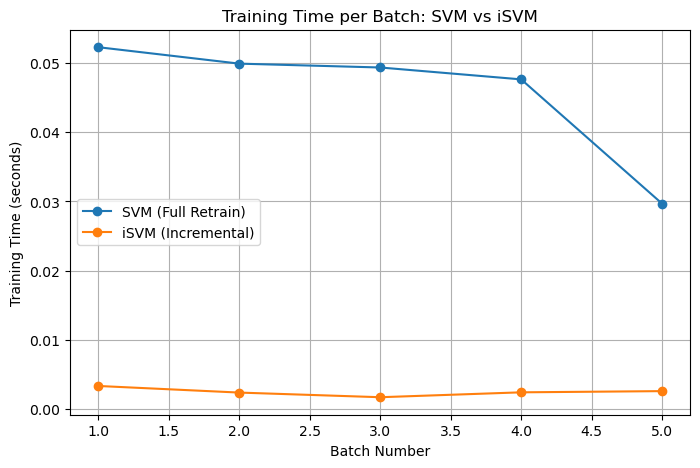

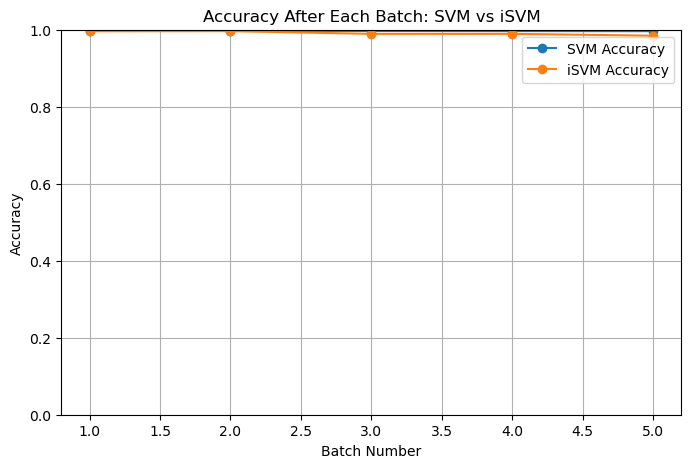

In [59]:
plt.figure(figsize=(8,5))
plt.plot(range(1, num_batches+1), svm_times, marker='o', label='SVM (Full Retrain)')
plt.plot(range(1, num_batches+1), isvm_times, marker='o', label='iSVM (Incremental)')
plt.title("Training Time per Batch: SVM vs iSVM")
plt.xlabel("Batch Number")
plt.ylabel("Training Time (seconds)")
plt.legend()
plt.grid(True)
plt.show()


plt.figure(figsize=(8,5))
plt.plot(range(1, num_batches+1), svm_accuracies, marker='o', label='SVM Accuracy')
plt.plot(range(1, num_batches+1), isvm_accuracies, marker='o', label='iSVM Accuracy')
plt.title("Accuracy After Each Batch: SVM vs iSVM")
plt.xlabel("Batch Number")
plt.ylabel("Accuracy")
plt.ylim(0,1)
plt.legend()
plt.grid(True)
plt.show()


In [73]:
fraud_df = df[df['is_fraud'] == 1]
fraud_df.head()


,Unnamed: 0,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,...,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud,age,hour
2449,2449,2019-01-02 01:06:37,4613314721966,fraud_Rutherford-Mertz,grocery_pos,281.06,Jason,Murphy,M,542 Steve Curve Suite 011,...,885,Soil scientist,1988-09-15,e8a81877ae9a0a7f883e15cb39dc4022,1325466397,36.430124,-81.179483,1,37,1
2472,2472,2019-01-02 01:47:29,340187018810220,"fraud_Jenkins, Hauck and Friesen",gas_transport,11.52,Misty,Hart,F,27954 Hall Mill Suite 575,...,1595797,Horticultural consultant,1960-10-28,bc7d41c41103877b03232f03f1f8d3f5,1325468849,29.819364,-99.142791,1,65,1
2523,2523,2019-01-02 03:05:23,340187018810220,fraud_Goodwin-Nitzsche,grocery_pos,276.31,Misty,Hart,F,27954 Hall Mill Suite 575,...,1595797,Horticultural consultant,1960-10-28,b98f12f4168391b2203238813df5aa8c,1325473523,29.273085,-98.836360,1,65,3
2546,2546,2019-01-02 03:38:03,4613314721966,fraud_Erdman-Kertzmann,gas_transport,7.03,Jason,Murphy,M,542 Steve Curve Suite 011,...,885,Soil scientist,1988-09-15,397894a5c4c02e3c61c784001f0f14e4,1325475483,35.909292,-82.091010,1,37,3
2553,2553,2019-01-02 03:55:47,340187018810220,fraud_Koepp-Parker,grocery_pos,275.73,Misty,Hart,F,27954 Hall Mill Suite 575,...,1595797,Horticultural consultant,1960-10-28,7863235a750d73a244c07f1fb7f0185a,1325476547,29.786426,-98.683410,1,65,3


In [74]:
fraud_df

,Unnamed: 0,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,...,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud,age,hour
2449,2449,2019-01-02 01:06:37,4613314721966,fraud_Rutherford-Mertz,grocery_pos,281.06,Jason,Murphy,M,542 Steve Curve Suite 011,...,885,Soil scientist,1988-09-15,e8a81877ae9a0a7f883e15cb39dc4022,1325466397,36.430124,-81.179483,1,37,1
2472,2472,2019-01-02 01:47:29,340187018810220,"fraud_Jenkins, Hauck and Friesen",gas_transport,11.52,Misty,Hart,F,27954 Hall Mill Suite 575,...,1595797,Horticultural consultant,1960-10-28,bc7d41c41103877b03232f03f1f8d3f5,1325468849,29.819364,-99.142791,1,65,1
2523,2523,2019-01-02 03:05:23,340187018810220,fraud_Goodwin-Nitzsche,grocery_pos,276.31,Misty,Hart,F,27954 Hall Mill Suite 575,...,1595797,Horticultural consultant,1960-10-28,b98f12f4168391b2203238813df5aa8c,1325473523,29.273085,-98.836360,1,65,3
2546,2546,2019-01-02 03:38:03,4613314721966,fraud_Erdman-Kertzmann,gas_transport,7.03,Jason,Murphy,M,542 Steve Curve Suite 011,...,885,Soil scientist,1988-09-15,397894a5c4c02e3c61c784001f0f14e4,1325475483,35.909292,-82.091010,1,37,3
2553,2553,2019-01-02 03:55:47,340187018810220,fraud_Koepp-Parker,grocery_pos,275.73,Misty,Hart,F,27954 Hall Mill Suite 575,...,1595797,Horticultural consultant,1960-10-28,7863235a750d73a244c07f1fb7f0185a,1325476547,29.786426,-98.683410,1,65,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1295399,1295399,2020-06-21 01:00:08,3524574586339330,fraud_Kassulke PLC,shopping_net,977.01,Ashley,Cabrera,F,94225 Smith Springs Apt. 617,...,105638,"Librarian, public",1986-05-07,a83b093f0c1d9068fa0089f7c722615f,1371776408,26.888686,-80.834389,1,39,1
1295491,1295491,2020-06-21 01:53:35,3524574586339330,fraud_Schumm PLC,shopping_net,1210.91,Ashley,Cabrera,F,94225 Smith Springs Apt. 617,...,105638,"Librarian, public",1986-05-07,f75b35bed13b9e692f170dba45a15b21,1371779615,28.216707,-79.855648,1,39,1
1295532,1295532,2020-06-21 02:16:56,4005676619255478,"fraud_Tillman, Dickinson and Labadie",gas_transport,10.24,William,Perry,M,458 Phillips Island Apt. 768,...,71335,Herbalist,1994-05-31,a0ba2472cd3fc9731f2a18d3f308f5c3,1371781016,29.700456,-91.361632,1,31,2
1295666,1295666,2020-06-21 03:26:20,3560725013359375,fraud_Corwin-Collins,gas_transport,21.69,Brooke,Smith,F,63542 Luna Brook Apt. 012,...,23,Cytogeneticist,1969-09-15,daa281350b1e16093c7b4bf97bf4d6ed,1371785180,32.675272,-103.484949,1,56,3


In [76]:
fraud_df.shape


(7506, 25)